In [1]:
# Plotting stuff
import pyqtgraph as pg
import matplotlib.pyplot as plt
import cmasher as cmr

# Science stuff
import numpy as np
import pandas as pd
from spectres import spectres

# Astropy stuff
from astropy.io import fits
from astropy.table import Table
import astropy.units as u
from astropy.units.quantity import Quantity
from astropy.io.ascii import read as ascii_read


# General stuff
import logging
import sys
from pathlib import Path
from itertools import cycle

In [2]:
# zHunter stuff
from zhunter import DIRS
from zhunter import io
from zhunter.misc import set_up_linked_vb, get_vb_containing, convert_to_bins
from zhunter.colors import get_gradient
from zhunter.spectroscopic_system import SpecSystemModel, SpecSystem
from zhunter.MainGraphicsWidget import MainGraphicsWidget
from zhunter.data_handler import DataHandler

In [3]:
# astropalmerio stuff
import astropalmerio.io as io
import astropalmerio.spectra as sp
import astropalmerio.galaxies as gal
import astropalmerio.mc as mc
from astropalmerio.spectra import ergscm2AA
from astropalmerio.spectra import EmissionLine
from specutils import Spectrum1D

In [4]:
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)

In [5]:
def generate_fake_2D_spectrum(
    SNR=10,
    flux_scale=1e-17,
    seeing=1,
    spec_start=650,
    spat_start=-10,
    N_spec=1001,
    N_spat=101,
    spec_pix_scale=0.02,
    spat_pix_scale=0.16,
    spec_unit='nm',
    spat_unit='arcsec',
    emission_line=None,
    nodding=True,
    nod_throw=5,
):
    """
    """
    seeing_px = seeing/spat_pix_scale

    # Spectral dimension
    spec_end = spec_start + N_spec*spec_pix_scale
    spec_mid = np.linspace(spec_start, spec_end, N_spec)

    # Spatial dimension
    spat_end = spat_start + N_spat*spat_pix_scale
    spat_mid = np.linspace(spat_start, spat_end, N_spat)

    flux = np.zeros((N_spat, N_spec))

    # Center trace
    trace_profile = sp.gaussian_fct(spat_mid, mean=np.median(spat_mid), stddev=sp.fwhm_to_sigma(seeing), amplitude=1)
    trace = trace_profile.reshape(N_spat,1) * np.ones(flux.shape)

    if emission_line:
        if isinstance(emission_line, bool):
            emission_line = {}

        # add an emission line
        em_line_1D = sp.gaussian_fct(
            spec_mid,
            mean=emission_line.get('mean',656.28),
            stddev=emission_line.get('stddev',1),
            amplitude=emission_line.get('amplitude',3),
        )
        em_line = np.outer(
            trace_profile.reshape(N_spat,1),
            em_line_1D.reshape(N_spec,1)
        )
        trace += em_line

    if nodding:
        # Negative traces to mimick nodding
        neg_trace_profile_u = -sp.gaussian_fct(spat_mid, mean=np.median(spat_mid)+nod_throw, stddev=sp.fwhm_to_sigma(seeing), amplitude=1)
        neg_trace_profile_l = -sp.gaussian_fct(spat_mid, mean=np.median(spat_mid)-nod_throw, stddev=sp.fwhm_to_sigma(seeing), amplitude=1)

        neg_trace_l = neg_trace_profile_l.reshape(N_spat,1) * np.ones(flux.shape)
        neg_trace_u = neg_trace_profile_u.reshape(N_spat,1) * np.ones(flux.shape)

        if emission_line:
            # add negative emission line
            neg_em_line_l = np.outer(
                neg_trace_profile_l.reshape(N_spat,1),
                em_line_1D.reshape(N_spec,1)
                
            )
            neg_em_line_u = np.outer(
                neg_trace_profile_u.reshape(N_spat,1),
                em_line_1D.reshape(N_spec,1)
            )
            neg_trace_l += neg_em_line_l
            neg_trace_u += neg_em_line_u

    # add noise
    flux += np.random.normal(0, 1./SNR, size=flux.shape)
    flux += trace + neg_trace_l + neg_trace_u
    flux *= flux_scale
    unc = flux_scale/SNR * np.ones(flux.shape)

    return spec_mid, spat_mid, flux, unc

In [7]:
def rebin_spectrum_2d(spectrum, binning_factors, uncertainty=None):
    """
    Rebin a 2D spectrum with optional error propagation.

    Parameters
    ----------
    spectrum : numpy.ndarray
        The input 2D spectrum to be rebinned.

    binning_factors : tuple of int
        A tuple of two integers (binning_factor_x, binning_factor_y) representing the binning factors
        for the x and y dimensions, respectively. Each binning factor must be greater than or equal to 1.

    uncertainty : numpy.ndarray, optional
        The 2D array of uncertainty associated with the input spectrum. If provided, uncertainty will be propagated
        in the rebinned spectrum. Must have the same dimensions as the input spectrum.

    Returns
    -------
    rebinned_spectrum : numpy.ndarray
        The rebinned 2D spectrum.

    rebinned_uncertainty : numpy.ndarray, optional
        The rebinned uncertainty, only returned if uncertainty are provided.

    Example
    -------
    >>> spectrum = np.array([[1, 2, 3, 4],
                             [5, 6, 7, 8],
                             [9, 10, 11, 12],
                             [13, 14, 15, 16]])
    >>> binning_factors = (2, 2)
    >>> uncertainty = np.array([[0.5, 0.5, 0.5, 0.5],
                           [0.5, 0.5, 0.5, 0.5],
                           [0.5, 0.5, 0.5, 0.5],
                           [0.5, 0.5, 0.5, 0.5]])
    >>> rebinned_spectrum, rebinned_uncertainty = rebin_spectrum_2d(spectrum, binning_factors, uncertainty)
    >>> print(rebinned_spectrum)
    [[14 22]
     [46 54]]
    >>> print(rebinned_uncertainty)
    [[1. 1.]
     [1. 1.]]
    """

    # Check that the input spectrum is a 2D numpy array
    if not isinstance(spectrum, np.ndarray) or spectrum.ndim != 2:
        raise ValueError("Input spectrum must be a 2D numpy array")

    if uncertainty is not None and not isinstance(uncertainty, np.ndarray):
        raise TypeError("Input uncertainty must be a numpy.ndarray, if provided.")

    if uncertainty is not None and spectrum.shape != uncertainty.shape:
        raise ValueError("Spectrum and uncertainty must have the same dimensions.")

    if (
        not isinstance(binning_factors, (list, tuple))
        or len(binning_factors) != 2
        or not all(isinstance(b, int) and b >= 1 for b in binning_factors)
    ):
        raise ValueError(
            "Binning factors must be a list or tuple of two integers greater than or equal to 1."
        )

    # Truncate input spectrum to fit the binning factors
    truncated_spectrum = spectrum[
        : (spectrum.shape[0] // binning_factors[0]) * binning_factors[0],
        : (spectrum.shape[1] // binning_factors[1]) * binning_factors[1],
    ]

    # Reshape the truncated spectrum
    reshaped_spectrum = truncated_spectrum.reshape(
        spectrum.shape[0] // binning_factors[0],
        binning_factors[0],
        spectrum.shape[1] // binning_factors[1],
        -1,
    )

    # Calculate rebinned spectrum using np.nansum
    rebinned_spectrum = np.nansum(reshaped_spectrum, axis=(1, 3))
    if uncertainty is not None:
        # Truncate and reshape uncertainty in the same way as the input spectrum
        truncated_uncertainty = uncertainty[
            : (uncertainty.shape[0] // binning_factors[0]) * binning_factors[0],
            : (uncertainty.shape[1] // binning_factors[1]) * binning_factors[1],
        ]

        reshaped_uncertainty = truncated_uncertainty.reshape(
            uncertainty.shape[0] // binning_factors[0],
            binning_factors[0],
            uncertainty.shape[1] // binning_factors[1],
            -1,
        )

        # Calculate rebinned uncertainty using np.nansum
        rebinned_uncertainty = np.sqrt(np.nansum(reshaped_uncertainty**2, axis=(1, 3)))
        return rebinned_spectrum, rebinned_uncertainty
    else:
        return rebinned_spectrum

In [29]:
spec_mid, spat_mid, flux, unc = generate_fake_2D_spectrum(
    SNR=10,
    spec_start=655,
    emission_line={'amplitude':1, 'stddev':0.1},
    N_spec=12,
    N_spat=11,
    spec_pix_scale=0.2,
    spat_pix_scale=1.6,
)

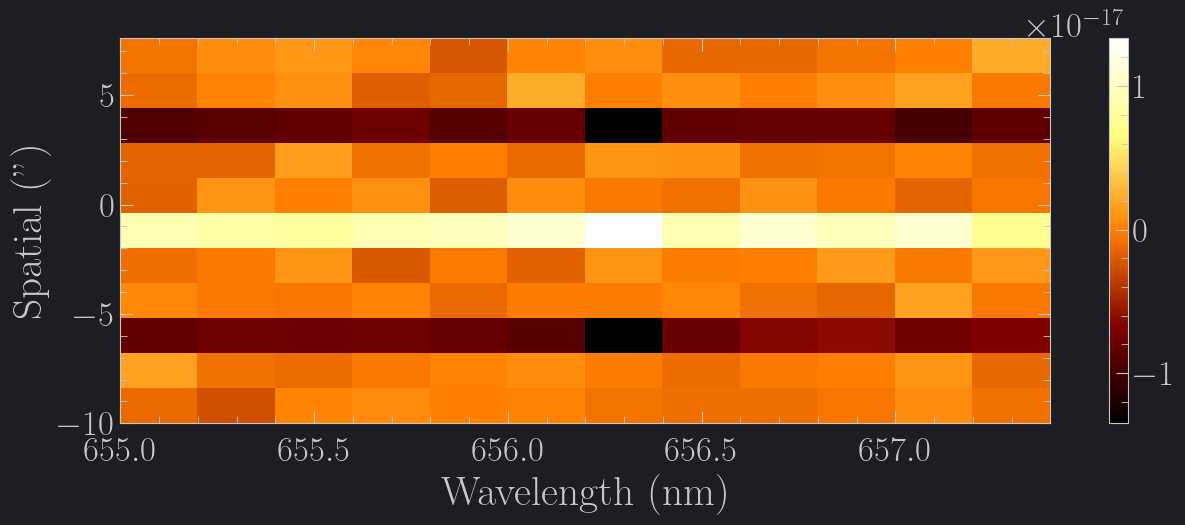

In [30]:
from astropy.visualization import ZScaleInterval, imshow_norm

plt.style.use('kraken')
plt.style.use('paper')
fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(flux, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           spec_mid[0],
                           spec_mid[-1],
                           spat_mid[0],
                           spat_mid[-1],
                       ],
                       cmap='afmhot',
                       interpolation='none',
                      )

plt.colorbar(im)
ax = plt.gca()
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial (")')

plt.show()

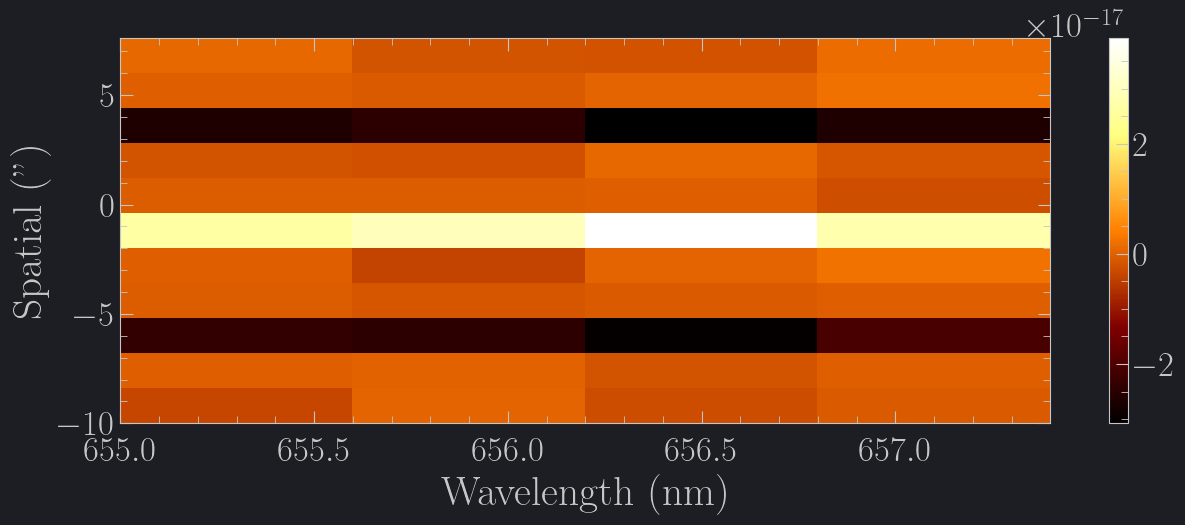

In [32]:
flux_rebin, unc_rebin = rebin_spectrum_2d(flux, binning_factors=(1,3), uncertainty=unc)

fig, ax = plt.subplots(figsize=(15,5))
# Plot 2D
im, norm = imshow_norm(flux_rebin, ax=ax, aspect='auto', origin='lower', 
                       interval=ZScaleInterval(contrast=0.5),
                       extent=[
                           spec_mid[0],
                           spec_mid[-1],
                           spat_mid[0],
                           spat_mid[-1],
                       ],
                       cmap='afmhot',
                       interpolation='none',
                      )

plt.colorbar(im)
ax = plt.gca()
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Spatial (")')

plt.show()